Copyright 2020-2022 John Penuel.  All rights reserved.


# Fekete Points


This notebook explores some randomized greedy heuristics to optimize the Fekete Points problem.  The Fekete Points problem seeks to minimize the "potential energy" of a system of points confined to a unit sphere.  The points repel each other, so if points are clumped closely together, the potential energy of the system is high.  You can think of this as electrons on a sphere.  At equilibrium, the points will be spread out evenly about the sphere.  

We write a few functions to visualize the results on the sphere in three dimensions.  




More details on the specific formulations can be found here:

* https://en.wikipedia.org/wiki/Fekete_problem
* https://en.wikipedia.org/wiki/Thomson_problem


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

In [2]:
#number of points
m = 30

#dimension of space... this code is not generic at this point and changing n!=3 will break plotting.
n = 3

#s-parameter
s = 1


#set random seed for repeatability
np.random.seed(17)        

In [3]:
starting_point = np.random.rand(n,m)
starting_point = starting_point - 0.5*np.ones((n,m))
for i in range(m):
    starting_point[:,i] = starting_point[:,i]/np.linalg.norm(starting_point[:,i])
    
point = np.zeros((n,m))

In [4]:
def plot_points(point,s):
    (n,m) = point.shape
    fig = plt.figure()
    plt.rcParams['figure.figsize'] = [10, 10]
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(point[0,:], point[1,:], point[2,:],c='r',s=20)
    ax.axis('off')
    cmax = 0
    for i in range(m-1):
        for j in range(i+1,m):
            c = np.linalg.norm(point[:,i]-point[:,j])**-s
            cmax = max(cmax,c)
    for i in range(m-1):
        for j in range(i+1,m):
            c = np.linalg.norm(point[:,i]-point[:,j])**-s
            ax.plot(point[0,[i,j]],point[1,[i,j]],point[2,[i,j]],color='blue',linewidth=c/cmax)
    plt.show()

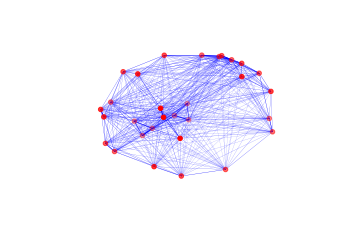

In [5]:
plot_points(starting_point,s)

This version only plots the triangles on the surface of the sphere.  We accept that more than 3 points can be on a plane, but we'll keep it simple for now.

In [6]:
def plot_points2(point,s):
    (n,m) = point.shape
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(point[0,:], point[1,:], point[2,:],c='r',s=20)
    ax.axis('off')
    triangles = []
    for i in range(m-2):
        for j in range(i+1,m-1):
            for k in range(j+1,m):
                t = np.cross(point[:,j]-point[:,i],point[:,k]-point[:,i])
                kquit = 0
                sLow = []
                sHigh = []
                for el in range(m):
                    if el != i:
                        if el != j:
                            if el != k:
                                c = np.dot(t,(point[:,el]-point[:,i]))
                                if c < 0:
                                    sLow.append(el)
                                else:
                                    sHigh.append(el)
                                if len(sLow) > 0 and len(sHigh) > 0:
                                    kquit = 1
                                    break
                if kquit == 0:
                    triangles.append([i,j,k])
    for t in triangles:
        i = t[0]
        j = t[1]
        k = t[2]
        c = np.linalg.norm(point[:,i]-point[:,j])**-s
        ax.plot(point[0,[i,j]],point[1,[i,j]],point[2,[i,j]],color='blue',linewidth=c/2)
        c = np.linalg.norm(point[:,i]-point[:,k])**-s
        ax.plot(point[0,[i,k]],point[1,[i,k]],point[2,[i,k]],color='blue',linewidth=c/2)
        c = np.linalg.norm(point[:,j]-point[:,k])**-s
        ax.plot(point[0,[j,k]],point[1,[j,k]],point[2,[j,k]],color='blue',linewidth=c/2)
    plt.show()    

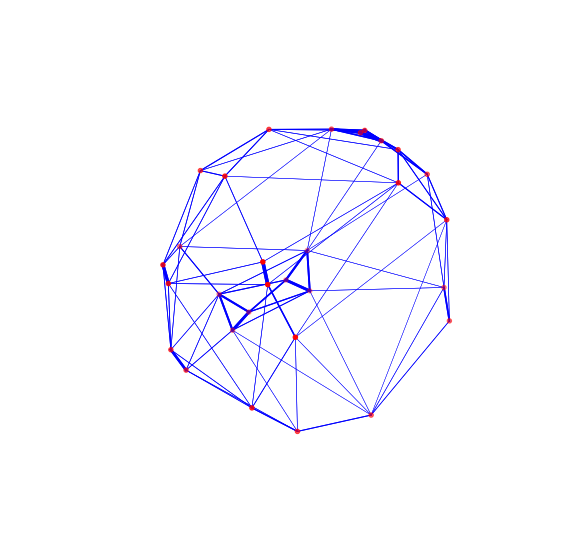

In [7]:
plot_points2(starting_point,s)

In [8]:
def evaluate_objective(point,s):
    (n,m) = point.shape
    obj = 0
    for i in range(m-1):
        for j in range(i+1,m):
            obj = obj + np.linalg.norm(point[:,i] - point[:,j])**-s
    return obj

In [9]:
iterations = 1500
performance = np.zeros((4,iterations))

### Pick-one-and-wiggle-it heuristic:

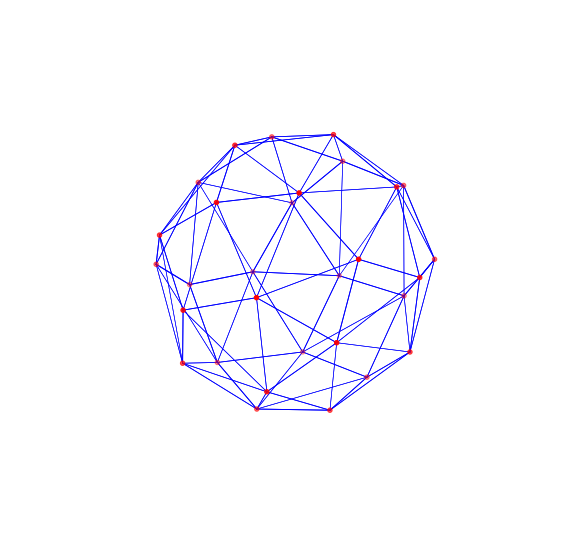

In [10]:
heuristic = 0
point[:,:] = starting_point


epsilon = 0.1 #epsilon should be tuned, but we leave it default for now.
for itr in range(iterations):
    c = evaluate_objective(point,s)
    performance[heuristic,itr] = c
    i = np.random.randint(m)
    temp_point = np.copy(point)
    temp_point[:,i] = temp_point[:,i] + epsilon*(np.random.rand(3) - 0.5*np.ones(3))
    temp_point[:,i] = temp_point[:,i]/np.linalg.norm(temp_point[:,i])
    c_temp = evaluate_objective(temp_point,s)
    if c_temp < c:
        c = c_temp
        point = np.copy(temp_point)
    performance[heuristic,itr] = c
        
        
plot_points2(point,s)

### Pick-one-and-push-it heuristic:

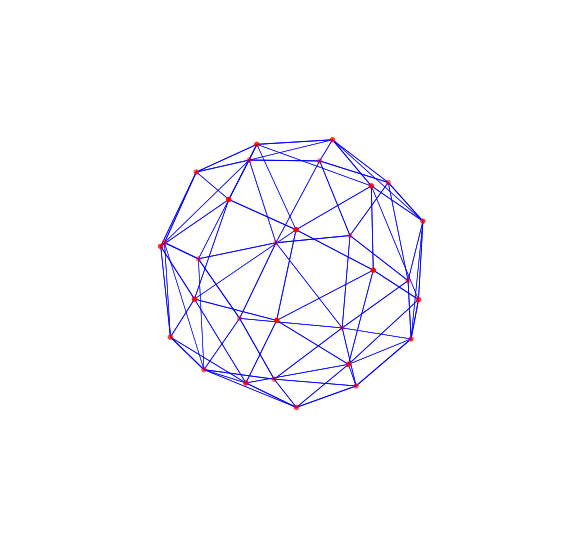

In [11]:
heuristic = 1
point = np.copy(starting_point)


epsilon = 0.1 #epsilon should be tuned, but we leave it default for now.
for itr in range(iterations):
    c = evaluate_objective(point,s)
    performance[heuristic,itr] = c
    i = np.random.randint(m)
    d = np.zeros(3)
    for j in range(m):
        if i != j:
            v = point[:,i] - point[:,j]
            a = np.linalg.norm(v)**-s
            v = a*v
            d = d + v
    d = epsilon*d
    point[:,i] = point[:,i] + d
    point[:,i] = point[:,i]/np.linalg.norm(point[:,i])

            
plot_points2(point,s)

### Select-node-with-most-potential-and-push-it heuristic:

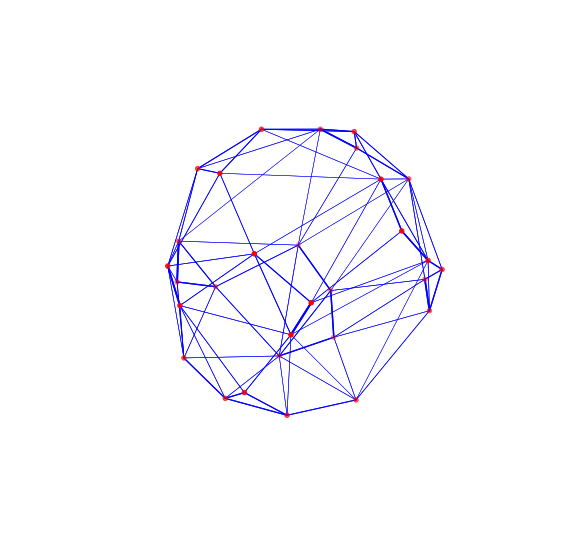

In [12]:
heuristic = 2
point = np.copy(starting_point)


epsilon = 0.1 #epsilon should be tuned, but we leave it default for now.
for itr in range(iterations):
    c = evaluate_objective(point,s)
    performance[heuristic,itr] = c
    max_e = 0
    ii = 0
    for i in range(m):
        e = 0
        for j in range(m):
            if i != j:
                e = e + np.linalg.norm(point[:,i]-point[:,j])**-s
        if e > max_e:
            max_e = e
            ii = i
    i = ii
    d = np.zeros(3)
    for j in range(m):
        if i != j:
            v = point[:,i] - point[:,j]
            a = np.linalg.norm(v)**-s
            v = a*v
            d = d + v
    d = epsilon*d
    point[:,i] = point[:,i] + d
    point[:,i] = point[:,i]/np.linalg.norm(point[:,i])
    
            
plot_points2(point,s)

### Select-node-with-most-potential-and-push-it heuristic ... with simulated annealing:

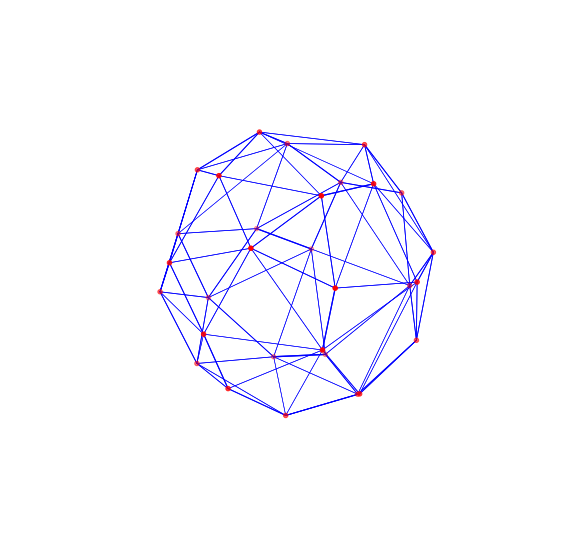

In [13]:
heuristic = 3
point = np.copy(starting_point)

epsilon = 0.1 #epsilon should be tuned, but we leave it default for now.
for itr in range(iterations):
    c = evaluate_objective(point,s)
    performance[heuristic,itr] = c
    if itr > 0:
        if abs(performance[heuristic,itr] - performance[heuristic,itr-1]) < 0.005: #stagnant. jiggle it.
            for i in range(m):
                point[:,i] = point[:,i] + 0.01*(np.random.rand(3) - 0.5*np.ones(3))
                point[:,i] = point[:,i]/np.linalg.norm(point[:,i])
    max_e = 0
    ii = 0
    for i in range(m):
        e = 0
        for j in range(m):
            if i != j:
                e = e + np.linalg.norm(point[:,i]-point[:,j])**-s
        if e > max_e:
            max_e = e
            ii = i
    i = ii
    d = np.zeros(3)
    for j in range(m):
        if i != j:
            v = point[:,i] - point[:,j]
            a = np.linalg.norm(v)**-s
            v = a*v
            d = d + v
    d = epsilon*d
    point[:,i] = point[:,i] + d
    point[:,i] = point[:,i]/np.linalg.norm(point[:,i])
    
    
        
plot_points2(point,s)

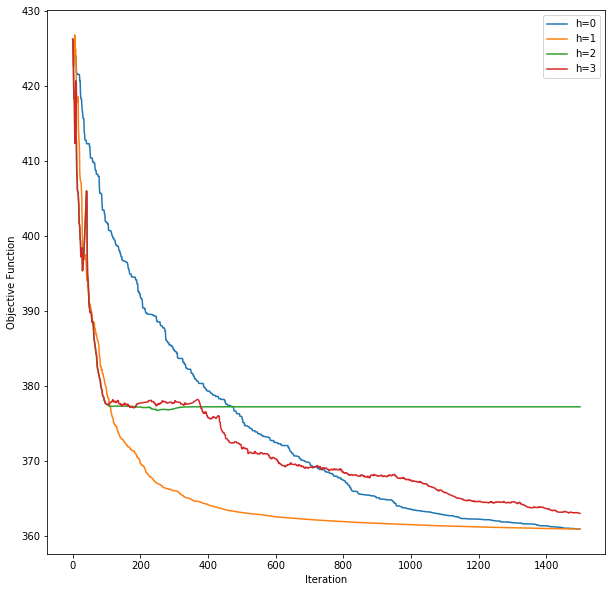

In [16]:
ax = plt.subplot(111)
(H,t) = performance.shape
for heuristic in range(H):
    plt.plot(performance[heuristic,:], label=f"h={heuristic}")
    
plt.legend(loc='upper right')
plt.xlabel("Iteration")
plt.ylabel("Objective Function")

plt.show()

* Heuristic 0 (h=0): pick random point, random move, only accept solution if better
* Heuristic 1 (h=1): pick random point, move in improving direction
* Heuristic 2 (h=2): pick point with most energy, move in improving direction
* Heuristic 3 (h=3): h=2, but with simulated annealing

Heuristic 1 seems to have the best performance.


Heuristic 2 drives the system down to a minimum slightly faster, but gets stuck in a local minimum (as opposed to global).


The added randomized selection in Heuristic 1 helps it to avoid the local minimum trap.


Heuristic 3 is just adding additional randomized movement to the system in an attempt to bump Heuristic 2 out of the local minimum. Heuristic 3 still doesn't converge as fast as we want it to, with performance comparable to the completely random Heuristic 0.


Future improvements include parameterizing (and tuning) all search, selection, movement and convergence thresholds. The most likely parameter to enhance peformance would be optimizing (at each iteration) the distance that the point is moved.